In [1]:
%matplotlib inline
import csv, random
from numpy import genfromtxt
import sys
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import GPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Applications/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
#Import dataset to the appropriate structure
import pandas as pd
data = pd.read_csv("istanbul_stock_exchange.csv")
df1 = data.iloc[2:] 
Original_dataset = df1.drop(df1.columns[0], axis=1)
df3 = Original_dataset.drop(Original_dataset.columns[0:2], axis = 1)
X = df3.values.astype(np.float)
df5 = Original_dataset.drop(Original_dataset.columns[1:], axis = 1)
y = df5.values.astype(np.float)

In [3]:
#Normalise the output
mean_y = y.mean()
y_norm = y-mean_y

In [4]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42)

In [ ]:
#Export train test split for savigp
np.savetxt('istanbul_train_X.csv',X_train,delimiter=",")
np.savetxt('istanbul_train_Y.csv',y_train,delimiter=",")
np.savetxt('istanbul_test_X.csv',X_test,delimiter=",")
np.savetxt('istanbul_test_Y.csv',y_test,delimiter=",")

In [54]:
X_train.shape

(428, 7)

In [5]:
#Plotting evaluation metric
opt_time = []
nlpd_mean = []
nlpd_std = []
nrmse = []
M_change = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

In [6]:
#All the predefined function
def init():
    kern = gpflow.kernels.RBF(X_train.shape[1],1)
    from scipy.cluster.vq import kmeans
    Z = kmeans(X_train, M)[0]
    m = gpflow.models.SVGP(X_train, y_train, kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X_train))
    return m

class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            self.logf.append(likelihood)
            
def run_opt (model, iterations,var_list=None):
    if var_list is None:
        var_list = [(model.q_mu, model.q_sqrt)]
    model.q_mu.set_trainable(False)
    model.q_sqrt.set_trainable(False)
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model) 
    model.q_mu.set_trainable(True)
    model.q_sqrt.set_trainable(True)
    natgrad=gpflow.training.NatGradOptimizer(1).make_optimize_action(model,var_list = var_list)
    logger = Logger(model)
    actions = [adam,natgrad,logger]
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    return logger

In [7]:
#Algorithm
for i in M_change:
    #Fitting model
    M = i
    m = init()
    m.X.set_batch_size(100)
    m.Y.set_batch_size(100)
    
    #Optimization process
    m.feature.trainable = False
    start_time = time.time()
    logger = run_opt(m, gpflow.test_util.notebook_niter(10000), var_list=[(m.q_mu, m.q_sqrt)])
    opt_time.append(time.time() - start_time)
    
    #NMSE calculation
    rmse = np.sqrt(mean_squared_error(y_test,m.predict_y(X_test)[0]))
    nrmse.append(rmse/(m.predict_y(X_test)[0].max()-m.predict_y(X_test)[0].min()))
    
    #Negative log probability density
    nlpd_mean.append(-m.predict_density(X_test,m.predict_y(X_test)[0]).mean())
    nlpd_std.append(np.std(m.predict_density(X_test,m.predict_y(X_test)[0])))
    

In [13]:
opt_time

[37.418776750564575,
 36.76880097389221,
 38.249845027923584,
 39.54224896430969,
 42.102298974990845,
 56.922653913497925,
 53.12680101394653,
 70.91277575492859,
 69.6593861579895,
 88.88036394119263,
 75.94887614250183,
 69.50786805152893,
 78.79511713981628,
 83.74998617172241,
 83.65990996360779,
 92.99820637702942,
 108.4788670539856,
 77.37360906600952,
 107.88425493240356,
 123.53239011764526]

In [ ]:
M_change

In [64]:
X_train.shape

(428, 7)

In [77]:
#Model fit
M = 100
m = init()

In [ ]:
#Mini-batch proportion estimation
ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(100)
m.Y.set_batch_size(100)
evals = [m.compute_log_likelihood() for _ in range(100)]
plt.hist(evals)
plt.axvline(ground_truth)
mbps = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in mbps:
    batchsize = int(len(X) * mbp)
    m.X.set_batch_size(batchsize)
    m.Y.set_batch_size(batchsize)
    start_time = time.time()
    objs.append([m.compute_log_likelihood() for _ in range(20)])
#    plt.hist(objs, bins = 100)
#    plt.axvline(ground_truth, color='r')
    times.append(time.time() - start_time)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(mbps, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(mbps, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

In [66]:
#Logger to save for plotting
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            self.logf.append(likelihood)

In [78]:
#Perform optimization algorithm
T = []
m.X.set_batch_size(100)
m.Y.set_batch_size(100)

m.feature.trainable = False

def run_opt (model, iterations,var_list=None):
    if var_list is None:
        var_list = [(model.q_mu, model.q_sqrt)]
    model.q_mu.set_trainable(False)
    model.q_sqrt.set_trainable(False)
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model) 
    model.q_mu.set_trainable(True)
    model.q_sqrt.set_trainable(True)
    natgrad=gpflow.training.NatGradOptimizer(1).make_optimize_action(model,var_list = var_list)
    logger = Logger(model)
    actions = [adam,natgrad,logger]
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    return logger


start_time = time.time()
logger = run_opt(m, gpflow.test_util.notebook_niter(10000), var_list=[(m.q_mu, m.q_sqrt)])
T.append(time.time()-start_time)

In [59]:
T

[116.95094871520996]

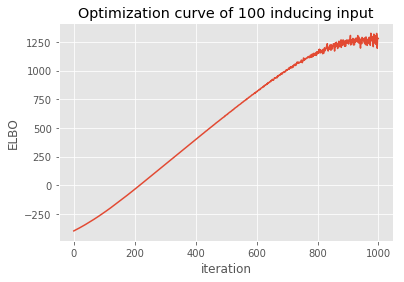

In [79]:
#Plotting for optimization algorithm
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('Optimization curve of 100 inducing input')
plt.savefig('Optim_curve_100.png',bbox_inches='tight')

In [ ]:
#Displaying all the parameters of the model
logger.model.as_pandas_table()

In [ ]:
#NMSE calculation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test,m.predict_y(X_test)[0])
nrmse.append(mse/np.std(y_train))

In [ ]:
#Negative log probability density
nlpd.append(-m.predict_density(X_test,y_test).mean())

Result for SAVIGP

In [8]:
import pandas
from sklearn.metrics import mean_squared_error
opt_time_savigp = [20.76385498,33.23706508,24.94821906,18.33838105,20.00274396,39.66500998,10.19832397,25.03943491,27.15037394,29.22906613,25.32615519,26.57341099,36.70211792,47.21070004,34.52809596,31.17112684,42.16800618,35.02816105,36.99580598,35.82616496]
nlpd_mean_savigp=[]
nlpd_std_savigp=[]
nmse_savigp=[]

In [9]:
for i in M_change:
    test_result = pandas.read_csv('testing_savigp/test_' + str(i) + '.csv')
    Ytrue = test_result["Ytrue0"].values.astype(np.float)
    Ypred = test_result["Ypred__0"].values.astype(np.float)
    NLPD = test_result["nlpd"].values.astype(np.float)
    rmse = np.sqrt(mean_squared_error(Ytrue,Ypred))
    nmse_savigp.append(rmse/((Ypred.max()-Ypred.min())))
    nlpd_mean_savigp.append(NLPD.mean()) 
    nlpd_std_savigp.append(np.std(NLPD))

 /Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:divide by zero encountered in double_scalars


In [32]:
for i in range(len(nmse_savigp)):
    if nmse_savigp[i] >= 1:
        nmse_savigp[i] = 1

In [33]:
nmse_savigp

[1,
 1,
 1,
 1,
 1,
 0.25155222531438848,
 1,
 1,
 1,
 1,
 1,
 1,
 0.29497978000746272,
 0.21624993744123727,
 0.27160188472956492,
 0.26965405795245162,
 0.26793713595960206,
 0.26614931681854614,
 0.26569687065474595,
 0.26352602614052983]

In [12]:
nlpd_mean_savigp

[-4.2250142046141628,
 -4.2250142541060134,
 -4.2230683382328404,
 -4.2153946966756877,
 -4.2183016297420499,
 -4.2286417488443719,
 -4.2250142474748884,
 -4.2218497619210256,
 -4.2219348114778787,
 -4.2218773424953362,
 -4.2217221846262936,
 -4.2211908760192838,
 -4.2504378522644375,
 -4.2515356024016793,
 -4.2543110117761955,
 -4.2552336485810347,
 -4.2561372022180857,
 -4.2568299833502703,
 -4.257458484309562,
 -4.258370309218428]

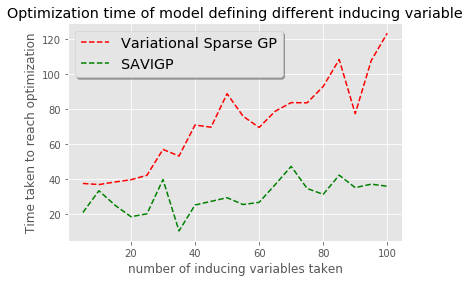

In [49]:
#Plot for optimization time
plt.title("Optimization time of model defining different inducing variable")
plt.xlabel("number of inducing variables taken")
plt.ylabel("Time taken to reach optimization")
plt.plot(M_change,opt_time,'r--',label="Variational Sparse GP")
plt.plot(M_change,opt_time_savigp,'g--',label = "SAVIGP")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.savefig('opt_time_istanbul.png', bbox_inches='tight')
plt.show()

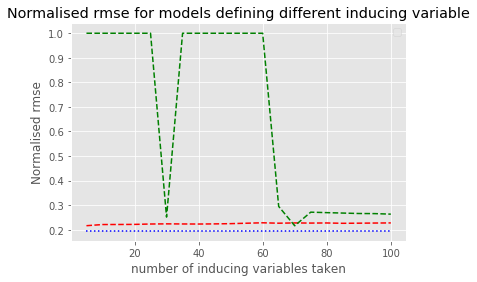

In [50]:
#Plot for nrmse
#inf replaced by 1 = indicating a bad nrmse
plt.title("Normalised rmse for models defining different inducing variable")
plt.xlabel("number of inducing variables taken")
plt.ylabel("Normalised rmse")
plt.legend()
plt.plot(M_change,nrmse,'r--',label="Variational Sparse GP")
plt.plot(M_change,nmse_savigp,'g--',label = "SAVIGP")
plt.hlines(y = 0.19525346882147659,xmin = 5,xmax=100,color='b',linestyles='dotted',label ='Full GP')
plt.savefig('nrmse_istanbul.png', bbox_inches='tight')
plt.show()

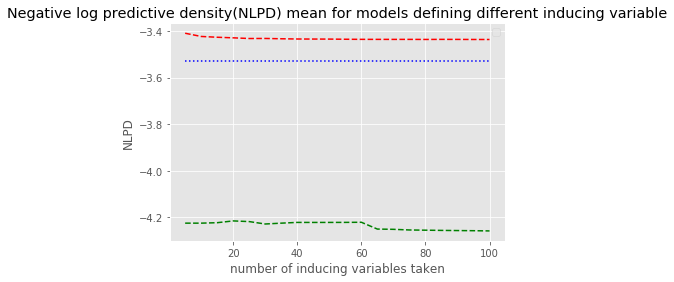

In [51]:
#Plot for nlpd mean
#inf replaced by 1 = indicating a bad nrmse
plt.title("Negative log predictive density(NLPD) mean for models defining different inducing variable")
plt.xlabel("number of inducing variables taken")
plt.ylabel("NLPD")
plt.legend()
plt.plot(M_change,nlpd_mean,'r--',label="Variational Sparse GP")
plt.plot(M_change,nlpd_mean_savigp,'g--',label = "SAVIGP")
plt.hlines(y = -3.527308816628338,xmin = 5,xmax=100,color='b',linestyles='dotted',label ='Full GP')
plt.savefig('nlpd_mean_istanbul.png', bbox_inches='tight')
plt.show()

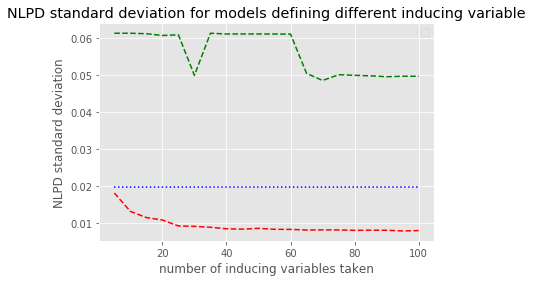

In [56]:
#Plot for nlpd std
plt.title("NLPD standard deviation for models defining different inducing variable")
plt.xlabel("number of inducing variables taken")
plt.ylabel("NLPD standard deviation")
plt.legend()
plt.plot(M_change,nlpd_std,'r--',label="Variational Sparse GP")
plt.plot(M_change,nlpd_std_savigp,'g--',label = "SAVIGP")
plt.hlines(y = 0.019671461237547417,xmin = 5,xmax=100,color='b',linestyles='dotted',label ='Full GP')
plt.savefig('nlpd_std_istanbul.png', bbox_inches='tight')
plt.show()

In [82]:
nmse_savigp

[1,
 1,
 1,
 1,
 1,
 0.25155222531438848,
 1,
 1,
 1,
 1,
 1,
 1,
 0.29497978000746272,
 0.21624993744123727,
 0.27160188472956492,
 0.26965405795245162,
 0.26793713595960206,
 0.26614931681854614,
 0.26569687065474595,
 0.26352602614052983]

In [84]:
nrmse

[0.21648838884788227,
 0.22121466576158999,
 0.22144322894512702,
 0.22181414199215427,
 0.22336691456071783,
 0.2240184419267629,
 0.22357594108747464,
 0.2232803855830654,
 0.22385928352741336,
 0.22482417102263333,
 0.22660833893359972,
 0.22834342887015402,
 0.22664740765698482,
 0.22778925049312693,
 0.22717150061151833,
 0.22761094833428697,
 0.22625698580879502,
 0.22672572888755166,
 0.22732445497592685,
 0.22779710149630328]

In [86]:
m

<generator object parameters at 0x1a424650a0>